# 1D GAN 실습

이 문서는 아래 자료를 참고하여 실습하면서 작성한 노트북입니다.

* [How to Develop a 1D Generative Adversarial Network From Scratch in Keras](https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-a-1-dimensional-function-from-scratch-in-keras/), Jason Brownlee

## 1 차원 함수 선택

$$
f(x) = x^2
$$

In [1]:
def calculate(x):
    return x * x

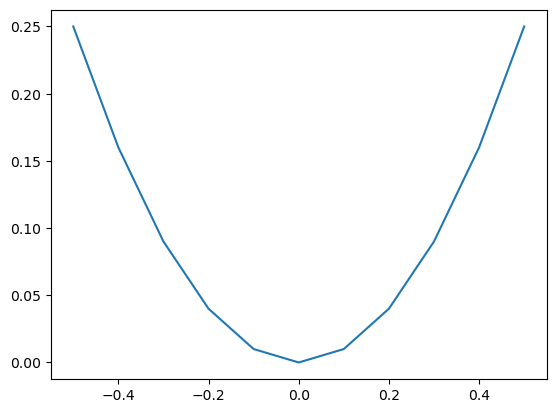

In [2]:
from matplotlib import pyplot

inputs = [-0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5]
outputs = [calculate(x) for x in inputs]

pyplot.plot(inputs, outputs)
pyplot.show()

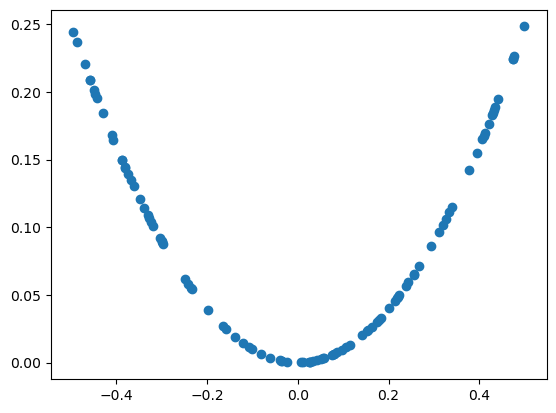

In [3]:
from numpy.random import rand
from numpy import hstack
from matplotlib import pyplot

def generate_samples(n=100):
    X1 = rand(n) - 0.5
    X2 = X1 * X1
    
    X1 = X1.reshape(n, 1)
    X2 = X2.reshape(n, 1)
    
    return hstack((X1, X2))

data = generate_samples()
pyplot.scatter(data[:, 0], data[:, 1])
pyplot.show()

## 판별자 모델 정의

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 25)                75        
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 101 (404.00 Byte)
Trainable params: 101 (404.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


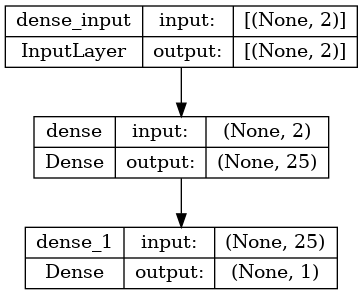

In [5]:
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import plot_model

def define_discriminator(n_inputs=2):
    model = Sequential()
    model.add(Dense(25, activation='relu', kernel_initializer='he_uniform', input_dim=n_inputs))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model = define_discriminator()
model.summary()
plot_model(model, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)

In [11]:
from numpy import ones

def generate_real_samples(n):
    X1 = rand(n) - 0.5
    X2 = X1 * X1
    
    X1 = X1.reshape(n, 1)
    X2 = X2.reshape(n, 1)
    
    X = hstack((X1, X2))
    y = ones((n, 1))
    
    return X, y

In [12]:
from numpy import zeros

def generate_fake_samples(n):
    X1 = -1 + rand(n) * 2
    X2 = -1 + rand(n) * 2

    
    X1 = X1.reshape(n, 1)
    X2 = X2.reshape(n, 1)
    
    X = hstack((X1, X2))
    y = zeros((n, 1))
    
    return X, y

In [17]:
# train the discriminator model
def train_discriminator(model, n_epochs=1000, n_batch=128):
    half_batch = int(n_batch / 2)
    
    # run epochs manually
    for i in range(n_epochs):
        # generate real examples
        X_real, y_real = generate_real_samples(half_batch)
        # update model
        model.train_on_batch(X_real, y_real)
        
        # generate fake examples
        X_fake, y_fake = generate_fake_samples(half_batch)
        # update model
        model.train_on_batch(X_fake, y_fake)
        
        # evaluate the model
        _, acc_real = model.evaluate(X_real, y_real, verbose=0)
        _, acc_fake = model.evaluate(X_fake, y_fake, verbose=0)
        
        if i < 5 or (n_epochs - 5) <= i or (i % 100 == 0):
            print(i, acc_real, acc_fake)

In [18]:
# define the discriminator model
model = define_discriminator()
# fit the model
train_discriminator(model)

0 1.0 0.28125
1 1.0 0.34375
2 1.0 0.28125
3 1.0 0.28125
4 1.0 0.28125
100 0.578125 0.59375
200 0.6875 0.828125
300 0.796875 0.859375
400 0.953125 0.9375
500 1.0 0.875
600 1.0 0.921875
700 1.0 0.859375
800 1.0 0.828125
900 1.0 0.84375
995 1.0 0.859375
996 1.0 0.890625
997 1.0 0.859375
998 1.0 0.859375
999 1.0 0.828125


## 생성자 모델 정의

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 15)                90        
                                                                 
 dense_11 (Dense)            (None, 2)                 32        
                                                                 
Total params: 122 (488.00 Byte)
Trainable params: 122 (488.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


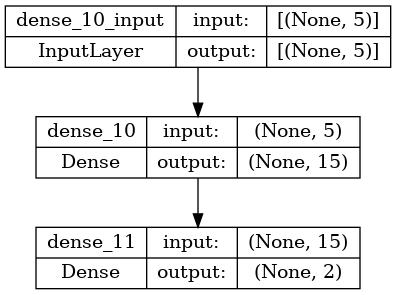

In [19]:
# define the standalone generator model
def define_generator(latent_dim, n_outputs=2):
    model = Sequential()
    model.add(Dense(15, activation='relu', kernel_initializer='he_uniform', input_dim=latent_dim))
    model.add(Dense(n_outputs, activation='linear'))
    return model

model = define_generator(5)
model.summary()
plot_model(model, to_file='generator_plot.png', show_shapes=True, show_layer_names=True)

In [25]:
from numpy.random import randn

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n):
    # generate points in the latent space
    x_input = randn(latent_dim * n)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n, latent_dim)
    return x_input

In [26]:
# use the generator to generate n fake examples and plot the results
def generate_fake_samples(generator, latent_dim, n):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n)
    # predict outputs
    X = generator.predict(x_input)
    # plot the results
    pyplot.scatter(X[:, 0], X[:, 1])
    pyplot.show()

4/4 [==============================] - 0s 1ms/step


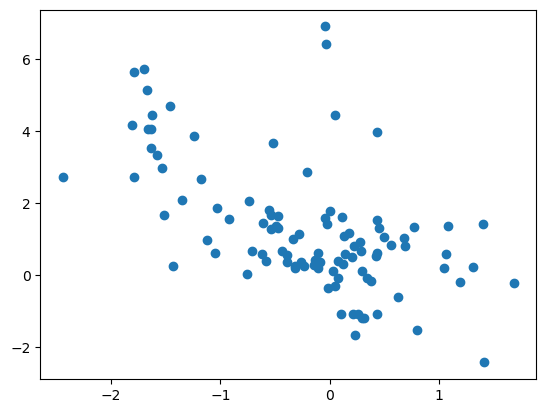

In [27]:
# size of the latent space
latent_dim = 5
# define the discriminator model
model = define_generator(latent_dim)
# generate and plot generated samples
generate_fake_samples(model, latent_dim, 100)

## 생성자 모델 훈련

In [28]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
    # make weights in the discriminator not trainable
    discriminator.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(generator)
    # add the discriminator
    model.add(discriminator)
    # compile model
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_9 (Sequential)   (None, 2)                 122       
                                                                 
 sequential_8 (Sequential)   (None, 1)                 101       
                                                                 
Total params: 223 (892.00 Byte)
Trainable params: 122 (488.00 Byte)
Non-trainable params: 101 (404.00 Byte)
_________________________________________________________________


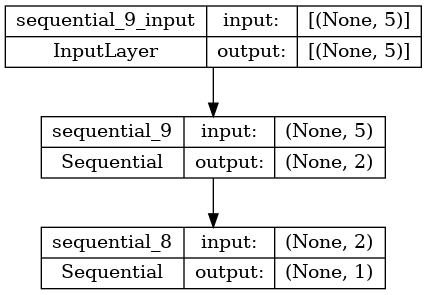

In [29]:
# size of the latent space
latent_dim = 5

# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)

# create the gan
gan_model = define_gan(generator, discriminator)
# summarize gan model
gan_model.summary()
# plot gan model
plot_model(gan_model, to_file='gan_plot.png', show_shapes=True, show_layer_names=True)

In [30]:
# train the composite model
def train_gan(gan_model, latent_dim, n_epochs=10000, n_batch=128):
    # manually enumerate epochs
    for i in range(n_epochs):
        # prepare points in latent space as input for the generator
        x_gan = generate_latent_points(latent_dim, n_batch)
        # create inverted labels for the fake samples
        y_gan = ones((n_batch, 1))
        # update the generator via the discriminator's error
        gan_model.train_on_batch(x_gan, y_gan)

In [31]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, latent_dim, n_epochs=10000, n_batch=128):
    # determine half the size of one batch, for updating the discriminator
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
        # prepare real samples
        x_real, y_real = generate_real_samples(half_batch)
        # prepare fake examples
        x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
        # update discriminator
        d_model.train_on_batch(x_real, y_real)
        d_model.train_on_batch(x_fake, y_fake)
        
        # prepare points in latent space as input for the generator
        x_gan = generate_latent_points(latent_dim, n_batch)
        # create inverted labels for the fake samples
        y_gan = ones((n_batch, 1))
        # update the generator via the discriminator's error
        gan_model.train_on_batch(x_gan, y_gan)

## GAN 성능 평가

In [32]:
# generate n real samples with class labels
def generate_real_samples(n):
    # generate inputs in [-0.5, 0.5]
    X1 = rand(n) - 0.5
    # generate outputs X^2
    X2 = X1 * X1
    # stack arrays
    X1 = X1.reshape(n, 1)
    X2 = X2.reshape(n, 1)
    X = hstack((X1, X2))
    # generate class labels
    y = ones((n, 1))
    return X, y

In [33]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n):
    # generate points in the latent space
    x_input = randn(latent_dim * n)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n, latent_dim)
    return x_input

In [34]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n)
    # predict outputs
    X = generator.predict(x_input)
    # create class labels
    y = zeros((n, 1))
    return X, y

In [35]:
# plot real and fake points
def summarize_performance(generator, latent_dim, n=100):
    # prepare real samples
    x_real, y_real = generate_real_samples(n)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(generator, latent_dim, n)
    # scatter plot real and fake data points
    pyplot.scatter(x_real[:, 0], x_real[:, 1], color='red')
    pyplot.scatter(x_fake[:, 0], x_fake[:, 1], color='blue')
    pyplot.show()

In [36]:
# evaluate the discriminator and plot real and fake points
def summarize_performance(epoch, generator, discriminator, latent_dim, n=100):
    # prepare real samples
    x_real, y_real = generate_real_samples(n)
    # evaluate discriminator on real examples
    _, acc_real = discriminator.evaluate(x_real, y_real, verbose=0)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(generator, latent_dim, n)
    # evaluate discriminator on fake examples
    _, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)
    # summarize discriminator performance
    print(epoch, acc_real, acc_fake)
    # scatter plot real and fake data points
    pyplot.scatter(x_real[:, 0], x_real[:, 1], color='red')
    pyplot.scatter(x_fake[:, 0], x_fake[:, 1], color='blue')
    pyplot.show()

In [37]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, latent_dim, n_epochs=10000, n_batch=128, n_eval=2000):
    # determine half the size of one batch, for updating the discriminator
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
        # prepare real samples
        x_real, y_real = generate_real_samples(half_batch)
        # prepare fake examples
        x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
        # update discriminator
        d_model.train_on_batch(x_real, y_real)
        d_model.train_on_batch(x_fake, y_fake)
        # prepare points in latent space as input for the generator
        x_gan = generate_latent_points(latent_dim, n_batch)
        # create inverted labels for the fake samples
        y_gan = ones((n_batch, 1))
        # update the generator via the discriminator's error
        gan_model.train_on_batch(x_gan, y_gan)
        # evaluate the model every n_eval epochs
        if (i+1) % n_eval == 0:
            summarize_performance(i, g_model, d_model, latent_dim)

2/2 [==============================] - 0s 1ms/step


2/2 [==============================] - 0s 1ms/step


2/2 [==============================] - 0s 1ms/step


2/2 [==============================] - 0s 1ms/step


2/2 [==============================] - 0s 1ms/step


2/2 [==============================] - 0s 1ms/step


2/2 [==============================] - 0s 1ms/step


2/2 [==============================] - 0s 1ms/step


2/2 [==============================] - 0s 1ms/step


2/2 [==============================] - 0s 1ms/step


2/2 [==============================] - 0s 976us/step


2/2 [==============================] - 0s 1ms/step


4/4 [==============================] - 0s 788us/step
1999 0.7099999785423279 0.47999998927116394


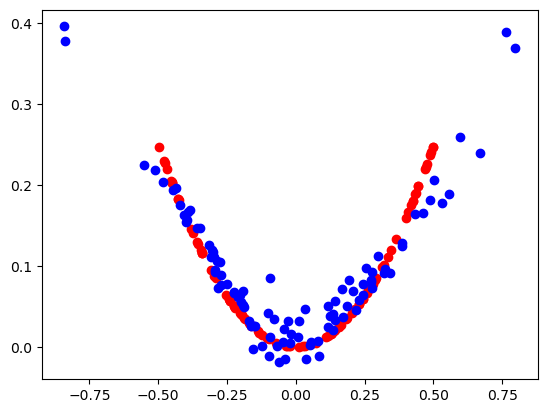

2/2 [==============================] - 0s 922us/step


2/2 [==============================] - 0s 1ms/step


2/2 [==============================] - 0s 988us/step


2/2 [==============================] - 0s 1ms/step


2/2 [==============================] - 0s 1ms/step


2/2 [==============================] - 0s 2ms/step


2/2 [==============================] - 0s 1ms/step


2/2 [==============================] - 0s 1ms/step


2/2 [==============================] - 0s 1ms/step


2/2 [==============================] - 0s 1ms/step


2/2 [==============================] - 0s 1ms/step


2/2 [==============================] - 0s 1ms/step


4/4 [==============================] - 0s 768us/step
3999 0.6700000166893005 0.5099999904632568


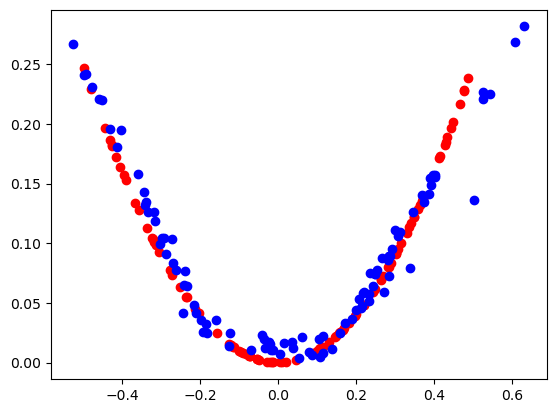

2/2 [==============================] - 0s 1ms/step


2/2 [==============================] - 0s 1ms/step


2/2 [==============================] - 0s 1ms/step


2/2 [==============================] - 0s 1ms/step


2/2 [==============================] - 0s 1ms/step


2/2 [==============================] - 0s 1ms/step


2/2 [==============================] - 0s 1ms/step


2/2 [==============================] - 0s 1ms/step


2/2 [==============================] - 0s 1ms/step


2/2 [==============================] - 0s 1ms/step


2/2 [==============================] - 0s 931us/step


2/2 [==============================] - 0s 1ms/step


4/4 [==============================] - 0s 758us/step
5999 0.5699999928474426 0.699999988079071


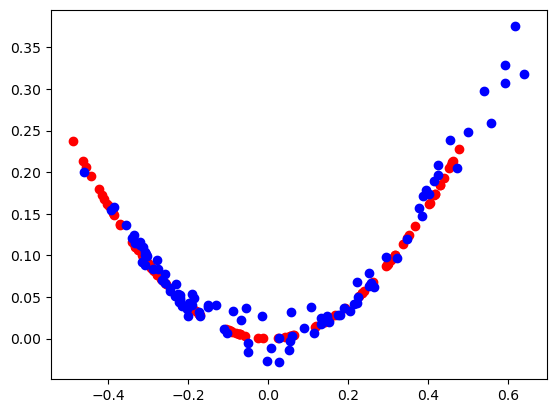

2/2 [==============================] - 0s 1ms/step


2/2 [==============================] - 0s 1ms/step


2/2 [==============================] - 0s 953us/step


2/2 [==============================] - 0s 1ms/step


2024-04-11 21:20:23.779479: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 1ms/step


2/2 [==============================] - 0s 1ms/step


2/2 [==============================] - 0s 1ms/step


2/2 [==============================] - 0s 1ms/step


2/2 [==============================] - 0s 1ms/step


2/2 [==============================] - 0s 988us/step


2/2 [==============================] - 0s 949us/step


2/2 [==============================] - 0s 1ms/step


4/4 [==============================] - 0s 749us/step
7999 0.550000011920929 0.5899999737739563


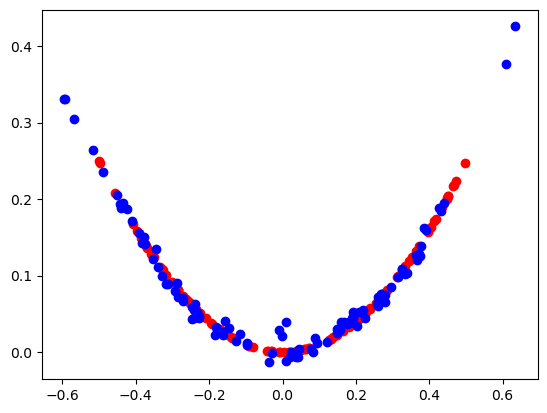

2/2 [==============================] - 0s 1ms/step


2/2 [==============================] - 0s 1ms/step


2/2 [==============================] - 0s 1ms/step


2/2 [==============================] - 0s 1ms/step


2/2 [==============================] - 0s 1ms/step


2/2 [==============================] - 0s 1ms/step


2/2 [==============================] - 0s 1ms/step


2/2 [==============================] - 0s 1ms/step


2/2 [==============================] - 0s 1ms/step


2/2 [==============================] - 0s 1ms/step


2/2 [==============================] - 0s 1ms/step


2/2 [==============================] - 0s 1ms/step


4/4 [==============================] - 0s 951us/step
9999 0.6100000143051147 0.5699999928474426


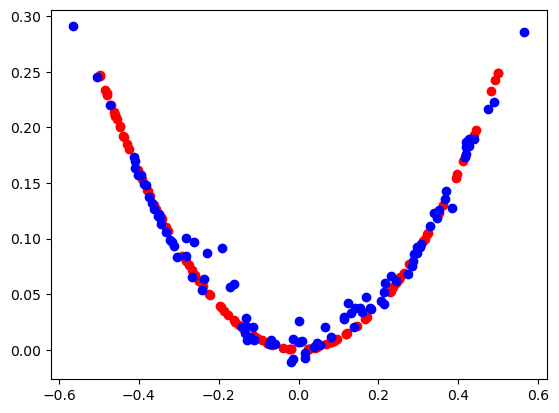

In [38]:
# size of the latent space
latent_dim = 5
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# train model
train(generator, discriminator, gan_model, latent_dim)